In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Circle
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import plotly.express as px
import random
from scipy.integrate import solve_ivp
import imageio
import os
import time
import csv
from scipy.stats import poisson
from scipy.stats import chisquare
import math
import pickle
from numba import njit
from numpy import genfromtxt

In [42]:
# Function for random gaussian variable 
def xi(size):
    e = np.random.uniform(0, 1, (2, size))
    r = np.sqrt(-2 * np.log(e[0]))
    arr = r * np.array([np.cos(2 * np.pi * e[1]), np.sin(2 * np.pi * e[1])])
    return np.column_stack((arr[0], arr[1]))

dt=0.1            #time-step
dx=0.01            #spatial grating

H=1                #dimensions of the box 
L=2

# x and y values helpful in doing grating.
x_values = np.arange(0, L, dx)
y_values = np.arange(0, H, dx) 

# x and y values helpful in doing statistics. "zer" helpful for storing numbers of particles in each gridbox
x_edges = np.arange(0, L + dx, dx)
y_edges = np.arange(0, H + dx, dx)
zer=np.zeros(np.size(x_values)*np.size(y_values))

#physics

C0= 2.1
eps= 0.001


C=0


k=(H*eps)**(2/3)
CT=10
CQ=10
pr=85000      #pressure

w=eps/k
wT=CT*w
wQ=CQ*w







Tt=278
dT=8
Tb=Tt+dT
Tmid=(Tt+Tb)/2

r0 = 10**(-6)

beta=C0*eps
sigma = np.sqrt((2/3)*k)
tau=4*k/(3*C0*eps)



def esw(T):
    return(661*np.exp((17.27*(T - 273.15))/((T - 273.15) + 237.7)))
eps2=0.622 #Rd/Rv




#function for supersaturation and initial conditions
ee = 0.622
e0 = 611.73
T00 = 273.16
Rv = 461.5
Lv0 = 2.5*10**6
p0=1013.25 * 10**2

def partialPressure(p,q):
    return p/(1+eps2/q)
def equiPressure(T):
    return e0*np.exp( (Lv0 / Rv) *(1/T00 - 1/T))
def superSat(p, T, q):
    return partialPressure(p,q)/equiPressure(T)-1

Qt=eps2*(equiPressure(Tt)/(pr-equiPressure(Tt))) 
Qb=eps2*(equiPressure(Tb)/(pr-equiPressure(Tb))) 

Qmid=eps2*(equiPressure(Tmid)/(pr-equiPressure(Tmid)))

Gt=(Tt-Tb)/H
Gq=(Qt-Qb)/H




#Condensational growth

rho=997         # density of water
rhod = 1.293    # density of dry air

ll= 2264.7*10**3   #latent heat of vaporization


def K(T):
    return 4.19*10**(-3)*(5.69 + 0.017*(T-(T00-0.01)))
def D(p,T):
    return 2.11 * 10**(-5)*(T/T00)**(1.94)*(p0/p)
def Fd(p,T):
    return (rho * Rv * T )/(D(p,T)*equiPressure(T))
def Fk(T):
    return rho*(ll**2)/(K(T)*Rv*T**2)
def effDiff(p,T):
    return 1/(Fk(T)+Fd(p,T))

cp=4.16*10**3 #specific isohoric heat capacity of water at 18deg C
    


#things connected with stochastic integrator 
#here I'll define some things in order not to calculate it a lot of times

expDtDtau = np.exp(-dt / tau)

b1 = np.sqrt(0.5 * (beta**2) * tau * (1 - np.exp(-2 * dt / tau)))
a1 = (0.5 * (beta**2) * (tau**2) * (1 - 2 * np.exp(-dt / tau) + np.exp(-2 * dt / tau))) / b1
a2 = np.sqrt(((beta**2) * (tau**2) * dt + 2 * (beta**2) * (tau**3) * (1 - np.exp(-dt / tau)) +
                0.5 * (beta**2) * (tau**3) * (1 - np.exp(-2 * dt / tau))) - a1**2)



Simulation with initial conditions at section __init__. Integrated according to Lemons. Possibility of inclusion of non-adiabatic side walls in section "non ASW"

In [43]:
class ParticlesStochastic:
    def __init__(self, N):                                                                          #N is number of particles
        self.N = N
        self.x = np.column_stack((np.random.uniform(0, L, self.N),  np.random.uniform(0, H, self.N)))         #uniform distribution of initial positions
        self.v = xi(self.N)*sigma                                                                        #normal distribution of initial velocities
        self.T = Tb+Gt * self.x[:, 1]
        self.Q = Qb + Gq * self.x[:, 1]

    #function to divide my domain into small rectangles and see what are the vertical distributions
    def rectanglesHorizontal(self, y_min, y_max):
        mask = (self.x[:, 1] >= y_min) & (self.x[:, 1] <= y_max)
        return np.column_stack((self.x[mask], self.T[mask], self.Q[mask]))    
    
    
    def timeStep(self):
        Qmean = np.mean(self.Q)
        Tmean = np.mean(self.T)
        #statistical coefficients for the particle
        a0 = self.x + self.v * tau * (1 - np.exp(-dt / tau)) + C * tau * dt + C * (tau**2) * np.exp(-dt / tau)
        b0 = self.v * np.exp(-dt / tau) + C * tau * (1 - np.exp(-dt / tau))
        b1 = np.sqrt(0.5 * (beta**2) * tau * (1 - np.exp(-2 * dt / tau)))
        a1 = (0.5 * (beta**2) * (tau**2) * (1 - 2 * np.exp(-dt / tau) + np.exp(-2 * dt / tau))) / b1
        a2 = np.sqrt(((beta**2) * (tau**2) * dt + 2 * (beta**2) * (tau**3) * (1 - np.exp(-dt / tau)) +
                      0.5 * (beta**2) * (tau**3) * (1 - np.exp(-2 * dt / tau))) - a1**2)

        
        # updating positions and velocities. x += a0 + a1*Gauss1 + a2* Gauss2. v += b0 + b1*Gauss1  
        randomGaussians1 = xi(self.N)
        randomGaussians2 = xi(self.N)
        
        self.x = a0 + a1*randomGaussians1 + a2*randomGaussians2          #a0 + a1*Gauss1 + a2* Gauss2
        self.v = b0 + b1*randomGaussians1                                 #b0+b1*Gauss1

        # updating temperatures and saturation vapor mixing ratio at temp T
        self.T += - (1 / 2) * wT * (self.T - Tmean) * dt
        self.Q += - (1 / 2) * wQ * (self.Q - Qmean) * dt
        
        #these are the particles that I'll apply bounduary conditions to
        outX0 = self.x[:, 0] < 0
        outXL = self.x[:, 0] > L
        outY0 = self.x[:, 1] < 0
        outYH = self.x[:, 1] > H
        
        #position bonduary conditions
        #in x
        self.x[outX0, 0] = -self.x[outX0, 0]
        self.x[outXL, 0] = 2*L - self.x[outXL, 0]
        #in y
        self.x[outY0, 1] = -self.x[outY0, 1]
        self.x[outYH, 1] = 2*H - self.x[outYH, 1]
        
        #velocity bonduary conditions
        self.v[outX0, 0] = -self.v[outX0, 0]
        self.v[outXL, 0] = -self.v[outXL, 0]
        self.v[outY0, 1] = -self.v[outY0, 1]
        self.v[outYH, 1] = -self.v[outYH, 1]
        
        #scalar variables bonduary conditions
        self.T[outY0] = Tb
        self.T[outYH] = Tt
        self.Q[outY0] = Qb  
        self.Q[outYH] = Qt
        
        #not ASW
        self.T[outX0] = Tmid
        self.T[outXL] = Tmid
        self.Q[outX0] = 0.95*Qmid
        self.Q[outXL] = 0.95*Qmid
        
        
    def run(self, maxTime):
        t = 0
        while t < maxTime:
            self.timeStep()
            t += dt
    #returns variance over mean, delta max over mean and 
    #the list of number of particles in each gridbox at the end of evaluation (handy for poisson check for different N)
            
    def spatialStd(self, maxTime):
        t = 0
        varOverMean = np.empty(0)
        deltaMaxOverMean = np.empty(0)

        while t < maxTime:
            self.timeStep()
            t += dt
            histSpatial, _, _ = np.histogram2d(self.x[:, 0], self.x[:, 1], bins=[x_edges, y_edges])
            zer = histSpatial.T.flatten()
            meanZer=np.mean(zer)
            varOverMean=np.append(varOverMean,np.var(zer)/meanZer)
            deltaMaxOverMean=np.append(deltaMaxOverMean,(np.max(zer)-np.min(zer))/meanZer)
        
    
                
        
                

        #return np.array([varOverMean,deltaMaxOverMean])
        return [varOverMean,deltaMaxOverMean,zer]

Evaluating the simultation (ParticleStochastic(<# of particles>)), simulating the system stoch.spatialStd(<# of seconds of simulation>)

In [ ]:
stoch=ParticlesStochastic(100000)
sym=stoch.spatialStd(100)


#export the results in the following format
#date_noOfParticles_typeOfModel_time_Ct_Cq_eps_Tb_dT
#typeOfModel
#adiabatic side-walls - asw 
#s100 - side-walls at temperature mid and 100 percent of equilibrium Q(T_mid)

#no growth - NoG



#saving the class after simulation
with open('20250703_100000_s95NoG_100_10_10_0001_278_8.pkl', 'wb') as file:
    pickle.dump(stoch, file)
    
#saving the statistics of notional particles (variance over mean of occupancy of small squares given by x_edges and y_edges, 
#absolute value of difference between the square with the most and the least particles, data to histogram of occupancy of squares)
with open('stata_20250703_100000_s95NoG_100_10_10_0001_278_8.pkl', 'wb') as file:
    pickle.dump(sym, file)

Importing already evaluated simulations 

In [3]:
with open('20250608_1000000_aswNoG_300_10_10_0001_280_19.pkl', 'rb') as file:
    asw = pickle.load(file)
with open('20250701_1000000_s100NoG_300_10_10_0001_280_19.pkl', 'rb') as file:
    s100 = pickle.load(file)
with open('20250701_1000000_s95NoG_300_10_10_0001_280_19.pkl', 'rb') as file:
    s95 = pickle.load(file)

Eulerian statistics

In [50]:
#divide my domain into stripes 
datasets = {
    'ASW': asw,
    's100': s100,
    's95': s95,
    's952': s952
}

stripes = {}

for label, dat in datasets.items():
    stripeWidth = 0.01
    yStripes = np.arange(0, H, stripeWidth)

    lisTmean = []
    lisTstd = []
    lisQmean = []
    lisQstd = []
    lisSmean = []
    lisSstd = []
    lisTQcov=[]
    lisTQcorr=[]
    count=0
    for i in np.arange(0, H, stripeWidth):
        count+=1
        particlesConsidered = dat.rectanglesHorizontal(i, i + stripeWidth)
        Tmean = np.mean(particlesConsidered[:, 2])
        Tstd = np.std(particlesConsidered[:, 2])
        Qmean = np.mean(particlesConsidered[:, 3])
        Qstd = np.std(particlesConsidered[:, 3])
        Smean = np.mean(superSat(pr, particlesConsidered[:, 2], particlesConsidered[:, 3]))
        Sstd = np.std(superSat(pr, particlesConsidered[:, 2], particlesConsidered[:, 3]))
        Te=particlesConsidered[:, 2]
        Qu=particlesConsidered[:, 3]
        cov=np.sum((Te - Tmean) * (Qu - Qmean)) / len(Te)
        corr=cov/(Tstd*Qstd)
            
        
        TQcorr=np.corrcoef(particlesConsidered[:, 2], particlesConsidered[:, 3])[0,1]

        lisTmean.append(Tmean)
        lisTstd.append(Tstd)
        lisQmean.append(Qmean)
        lisQstd.append(Qstd)
        lisSmean.append(Smean)
        lisSstd.append(Sstd)
        lisTQcov.append(cov)
        lisTQcorr.append(corr)
        '''if count%10==0:
            plt.figure(figsize=(8, 6))
            plt.scatter(Te,Qu)
            plt.xlim(-dT,dT) 
            plt.title(f"{label}, {count}")
            plt.show()
        '''

    # Save results using labels
    stripes[f'lisTmean{label}'] = np.array(lisTmean)
    stripes[f'lisTstd{label}']  = np.array(lisTstd)
    stripes[f'lisQmean{label}'] = np.array(lisQmean)
    stripes[f'lisQstd{label}']  = np.array(lisQstd)
    stripes[f'lisSmean{label}'] = np.array(lisSmean)
    stripes[f'lisSstd{label}']  = np.array(lisSstd)
    stripes[f'lisTQcorr{label}'] = np.array(lisTQcorr)
    stripes[f"lisTQcov{label}"] = np.array(lisTQcov)

Example plots of Eulerian statistics

C:\Users\igork\AppData\Local\Temp\ipykernel_25684\2673575336.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma', 6)


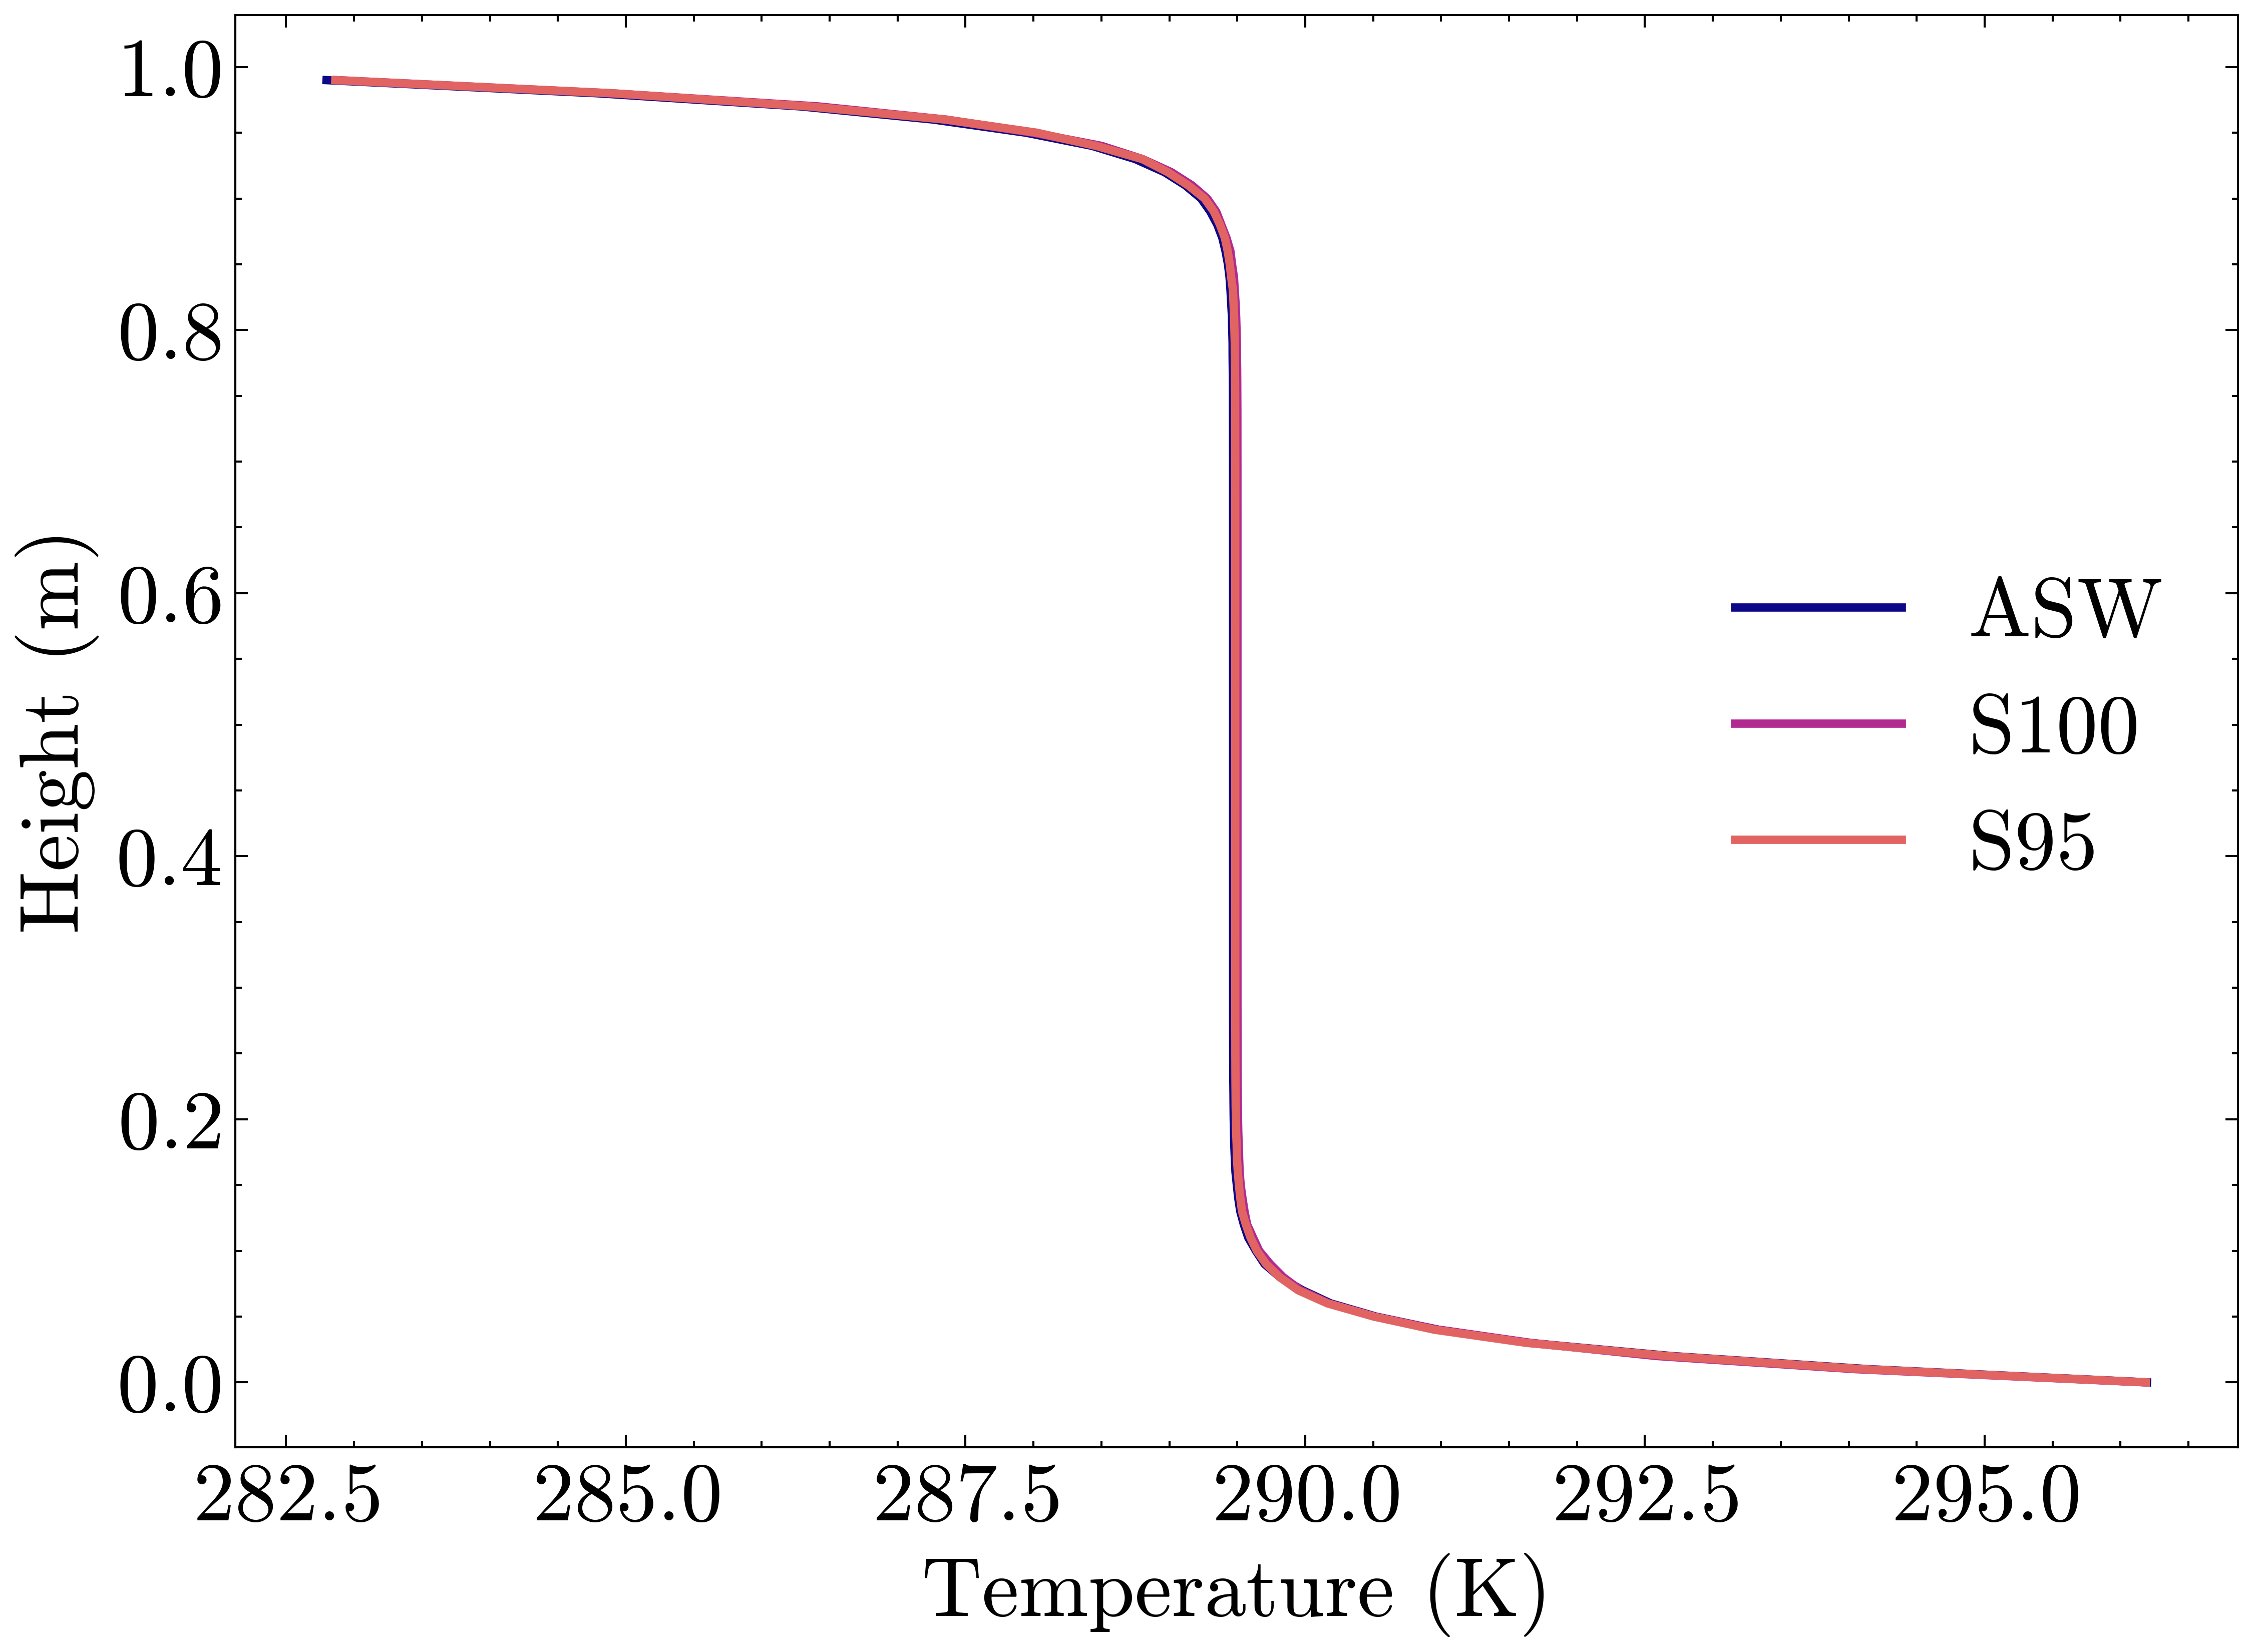

In [46]:
cmap = cm.get_cmap('plasma', 6) 
colors = cmap(np.linspace(0, 1, 6))


try:
    import scienceplots
    plt.style.use(['science', 'ieee', 'no-latex'])  # PRX-style approximation
except ImportError:
    print("scienceplots not found. Using default style.")
    plt.style.use('default')

# Adjust font sizes (slightly smaller than before)
plt.rcParams.update({
    'font.size': 20,          # Base font size
    'axes.titlesize': 20,     # Title
    'axes.labelsize': 20,     # Axis labels
    'legend.fontsize': 20,    # Legend
    'xtick.labelsize': 20,    # Tick labels
    'ytick.labelsize': 20
})



# Create scatter plot
plt.figure(figsize=(8, 6))


plt.plot(stripes['lisTmeanASW'], yStripes, color=colors[0],linestyle='-', linewidth=2, label='ASW')
plt.plot(stripes['lisTmeans100'], yStripes, color=colors[2], linestyle='-', linewidth=2,label='S100')
plt.plot(stripes['lisTmeans95'], yStripes, color=colors[3],linestyle='-', linewidth=2, label='S95')


# Add labels and title
plt.xlabel('Temperature (K)')
plt.ylabel('Height (m)')
plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("Temp_sw.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\igork\AppData\Local\Temp\ipykernel_25684\708429310.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma', 6)


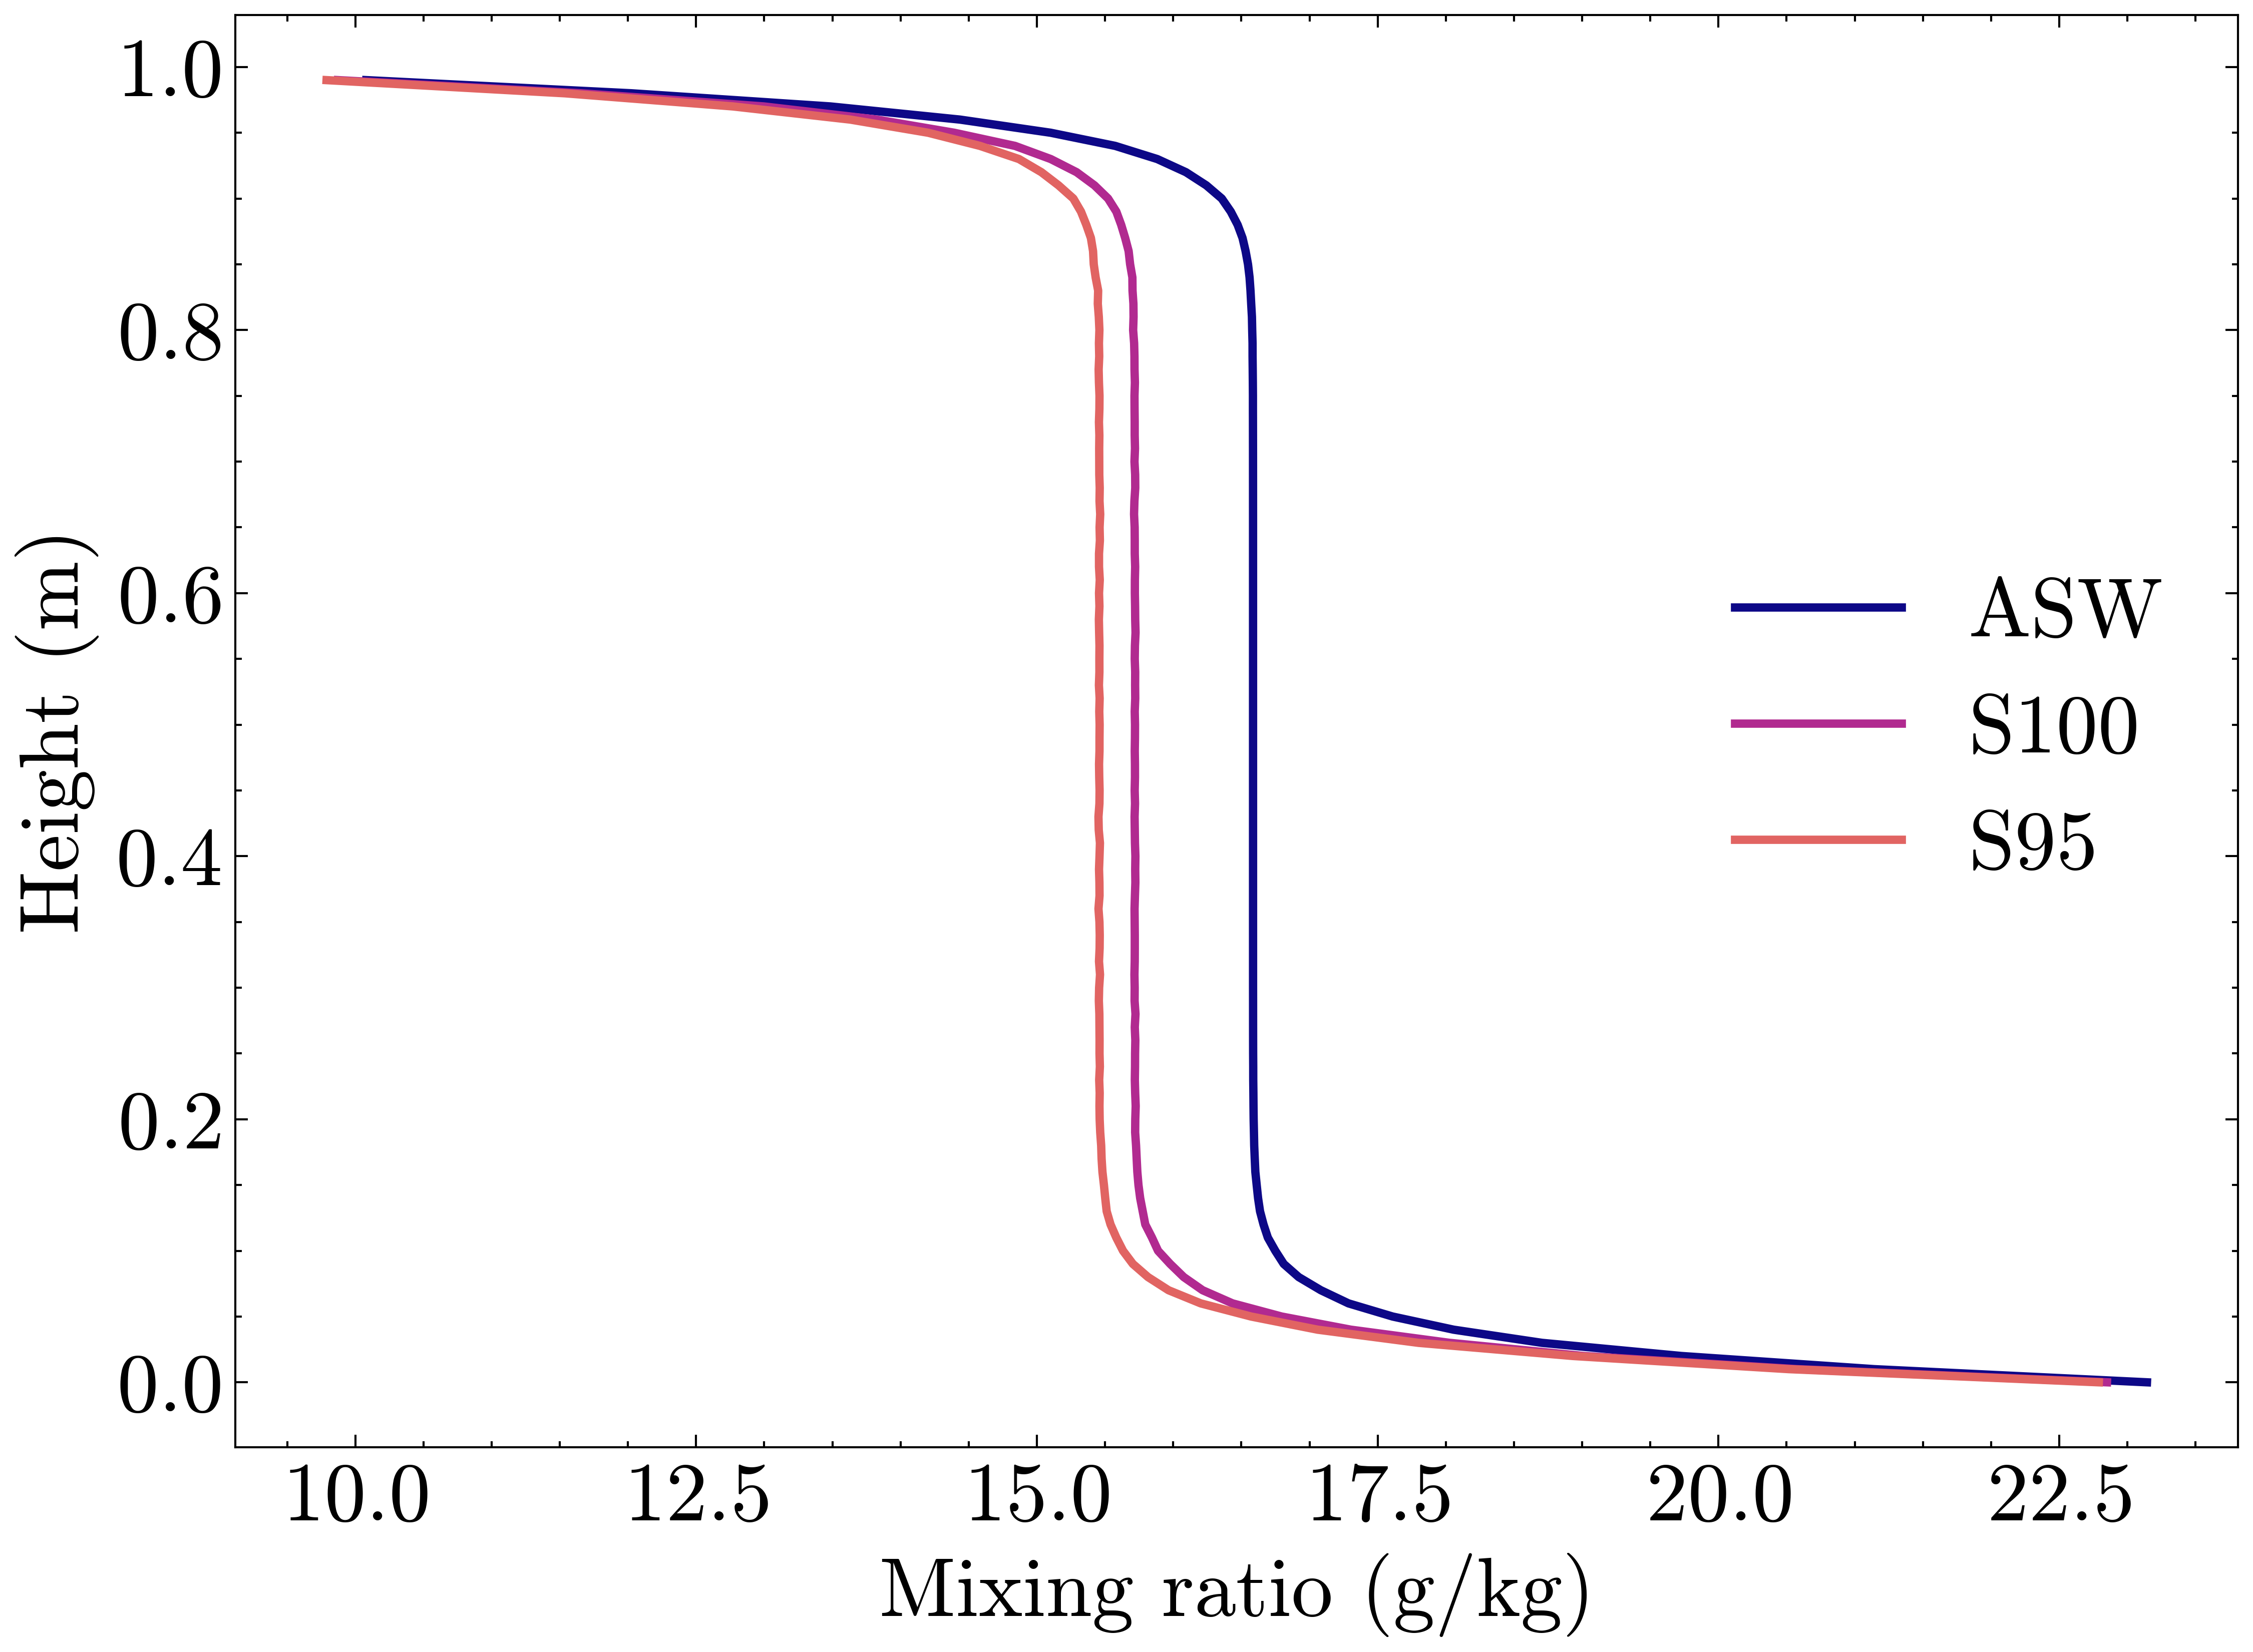

In [45]:
cmap = cm.get_cmap('plasma', 6) 
colors = cmap(np.linspace(0, 1, 6))


try:
    import scienceplots
    plt.style.use(['science', 'ieee', 'no-latex'])  # PRX-style approximation
except ImportError:
    print("scienceplots not found. Using default style.")
    plt.style.use('default')

# Adjust font sizes (slightly smaller than before)
plt.rcParams.update({
    'font.size': 20,          # Base font size
    'axes.titlesize': 20,     # Title
    'axes.labelsize': 20,     # Axis labels
    'legend.fontsize': 20,    # Legend
    'xtick.labelsize': 20,    # Tick labels
    'ytick.labelsize': 20
})



# Create scatter plot
plt.figure(figsize=(8, 6))


plt.plot(1000*stripes['lisQmeanASW'], yStripes, color=colors[0],linestyle='-', linewidth=2, label='ASW')
plt.plot(1000*stripes['lisQmeans100'], yStripes, color=colors[2], linestyle='-', linewidth=2,label='S100')
plt.plot(1000*stripes['lisQmeans95'], yStripes, color=colors[3],linestyle='-', linewidth=2, label='S95')


# Add labels and title
plt.xlabel('Mixing ratio (g/kg)')
plt.ylabel('Height (m)')
plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("Q_sw.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\igork\AppData\Local\Temp\ipykernel_25684\2399042621.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma', 6)


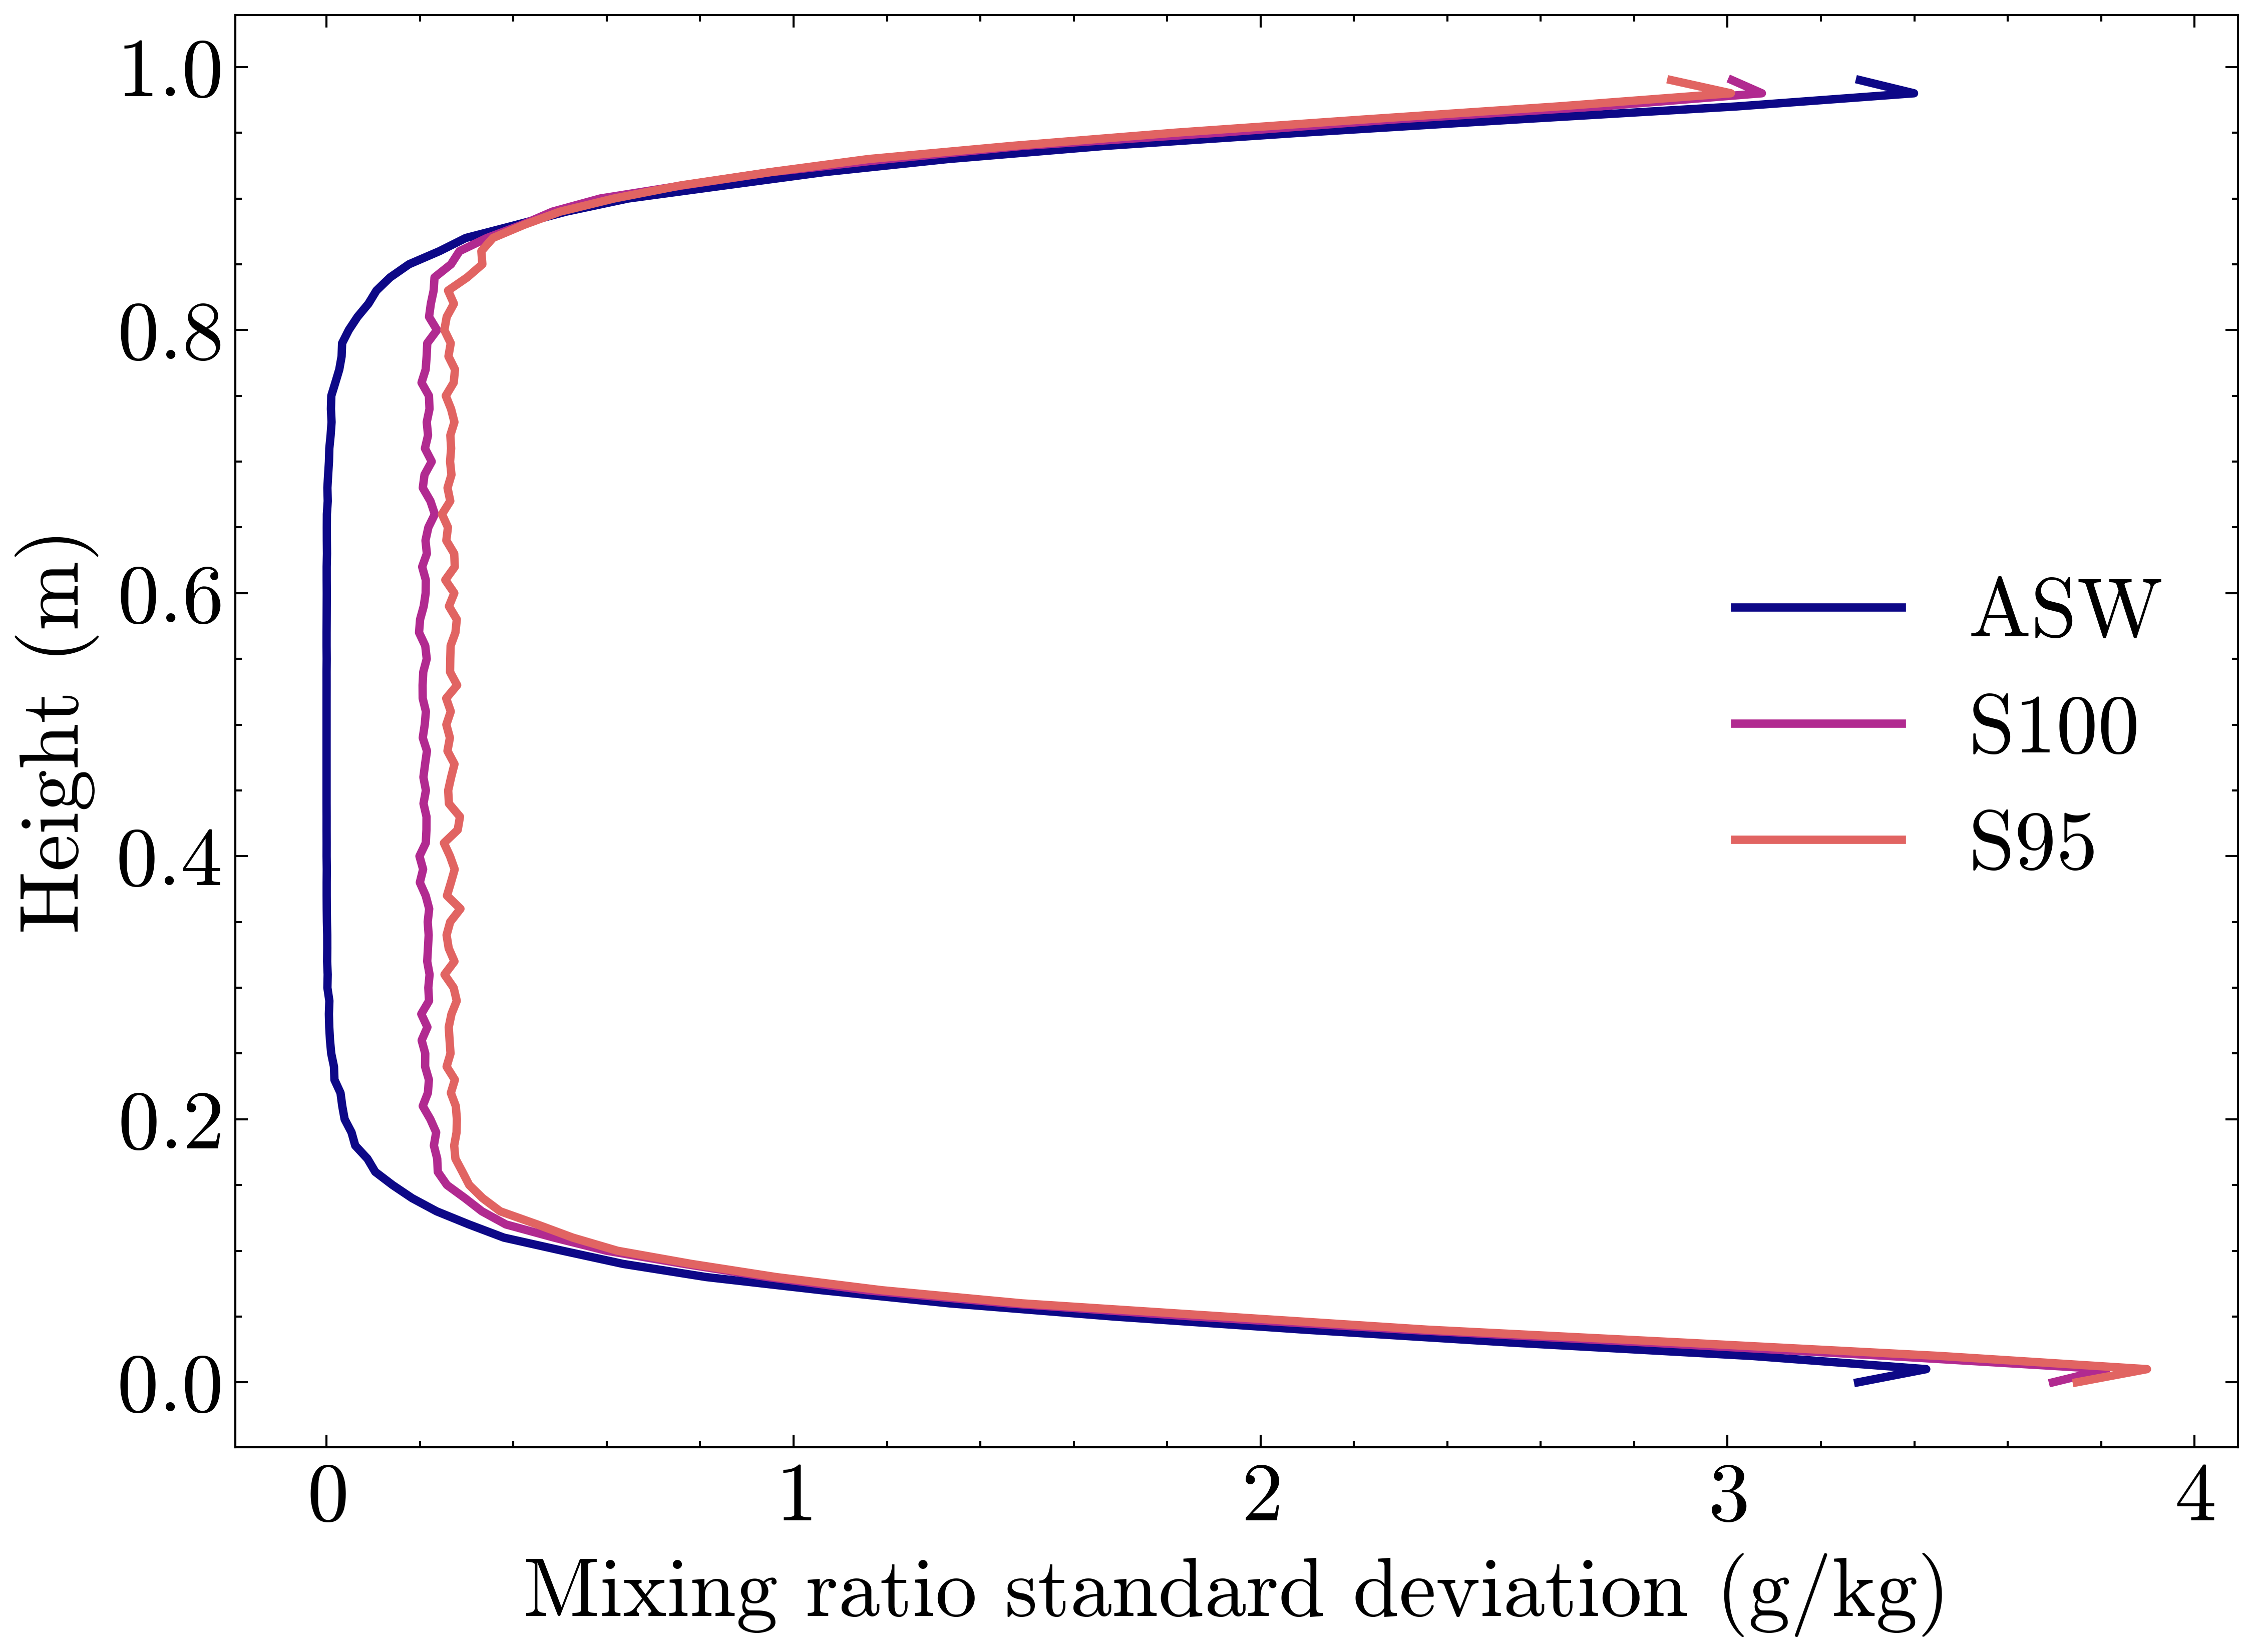

In [51]:
cmap = cm.get_cmap('plasma', 6) 
colors = cmap(np.linspace(0, 1, 6))


try:
    import scienceplots
    plt.style.use(['science', 'ieee', 'no-latex'])  # PRX-style approximation
except ImportError:
    print("scienceplots not found. Using default style.")
    plt.style.use('default')

# Adjust font sizes (slightly smaller than before)
plt.rcParams.update({
    'font.size': 20,          # Base font size
    'axes.titlesize': 20,     # Title
    'axes.labelsize': 20,     # Axis labels
    'legend.fontsize': 20,    # Legend
    'xtick.labelsize': 20,    # Tick labels
    'ytick.labelsize': 20
})



# Create scatter plot
plt.figure(figsize=(8, 6))


plt.plot(1000*stripes['lisQstdASW'], yStripes, color=colors[0],linestyle='-', linewidth=2, label='ASW')
plt.plot(1000*stripes['lisQstds100'], yStripes, color=colors[2], linestyle='-', linewidth=2,label='S100')
plt.plot(1000*stripes['lisQstds95'], yStripes, color=colors[3],linestyle='-', linewidth=2, label='S95')


# Add labels and title
plt.xlabel('Mixing ratio standard deviation (g/kg)')
plt.ylabel('Height (m)')
plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("Q_std_sw.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\igork\AppData\Local\Temp\ipykernel_25684\1291497784.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma', 6)


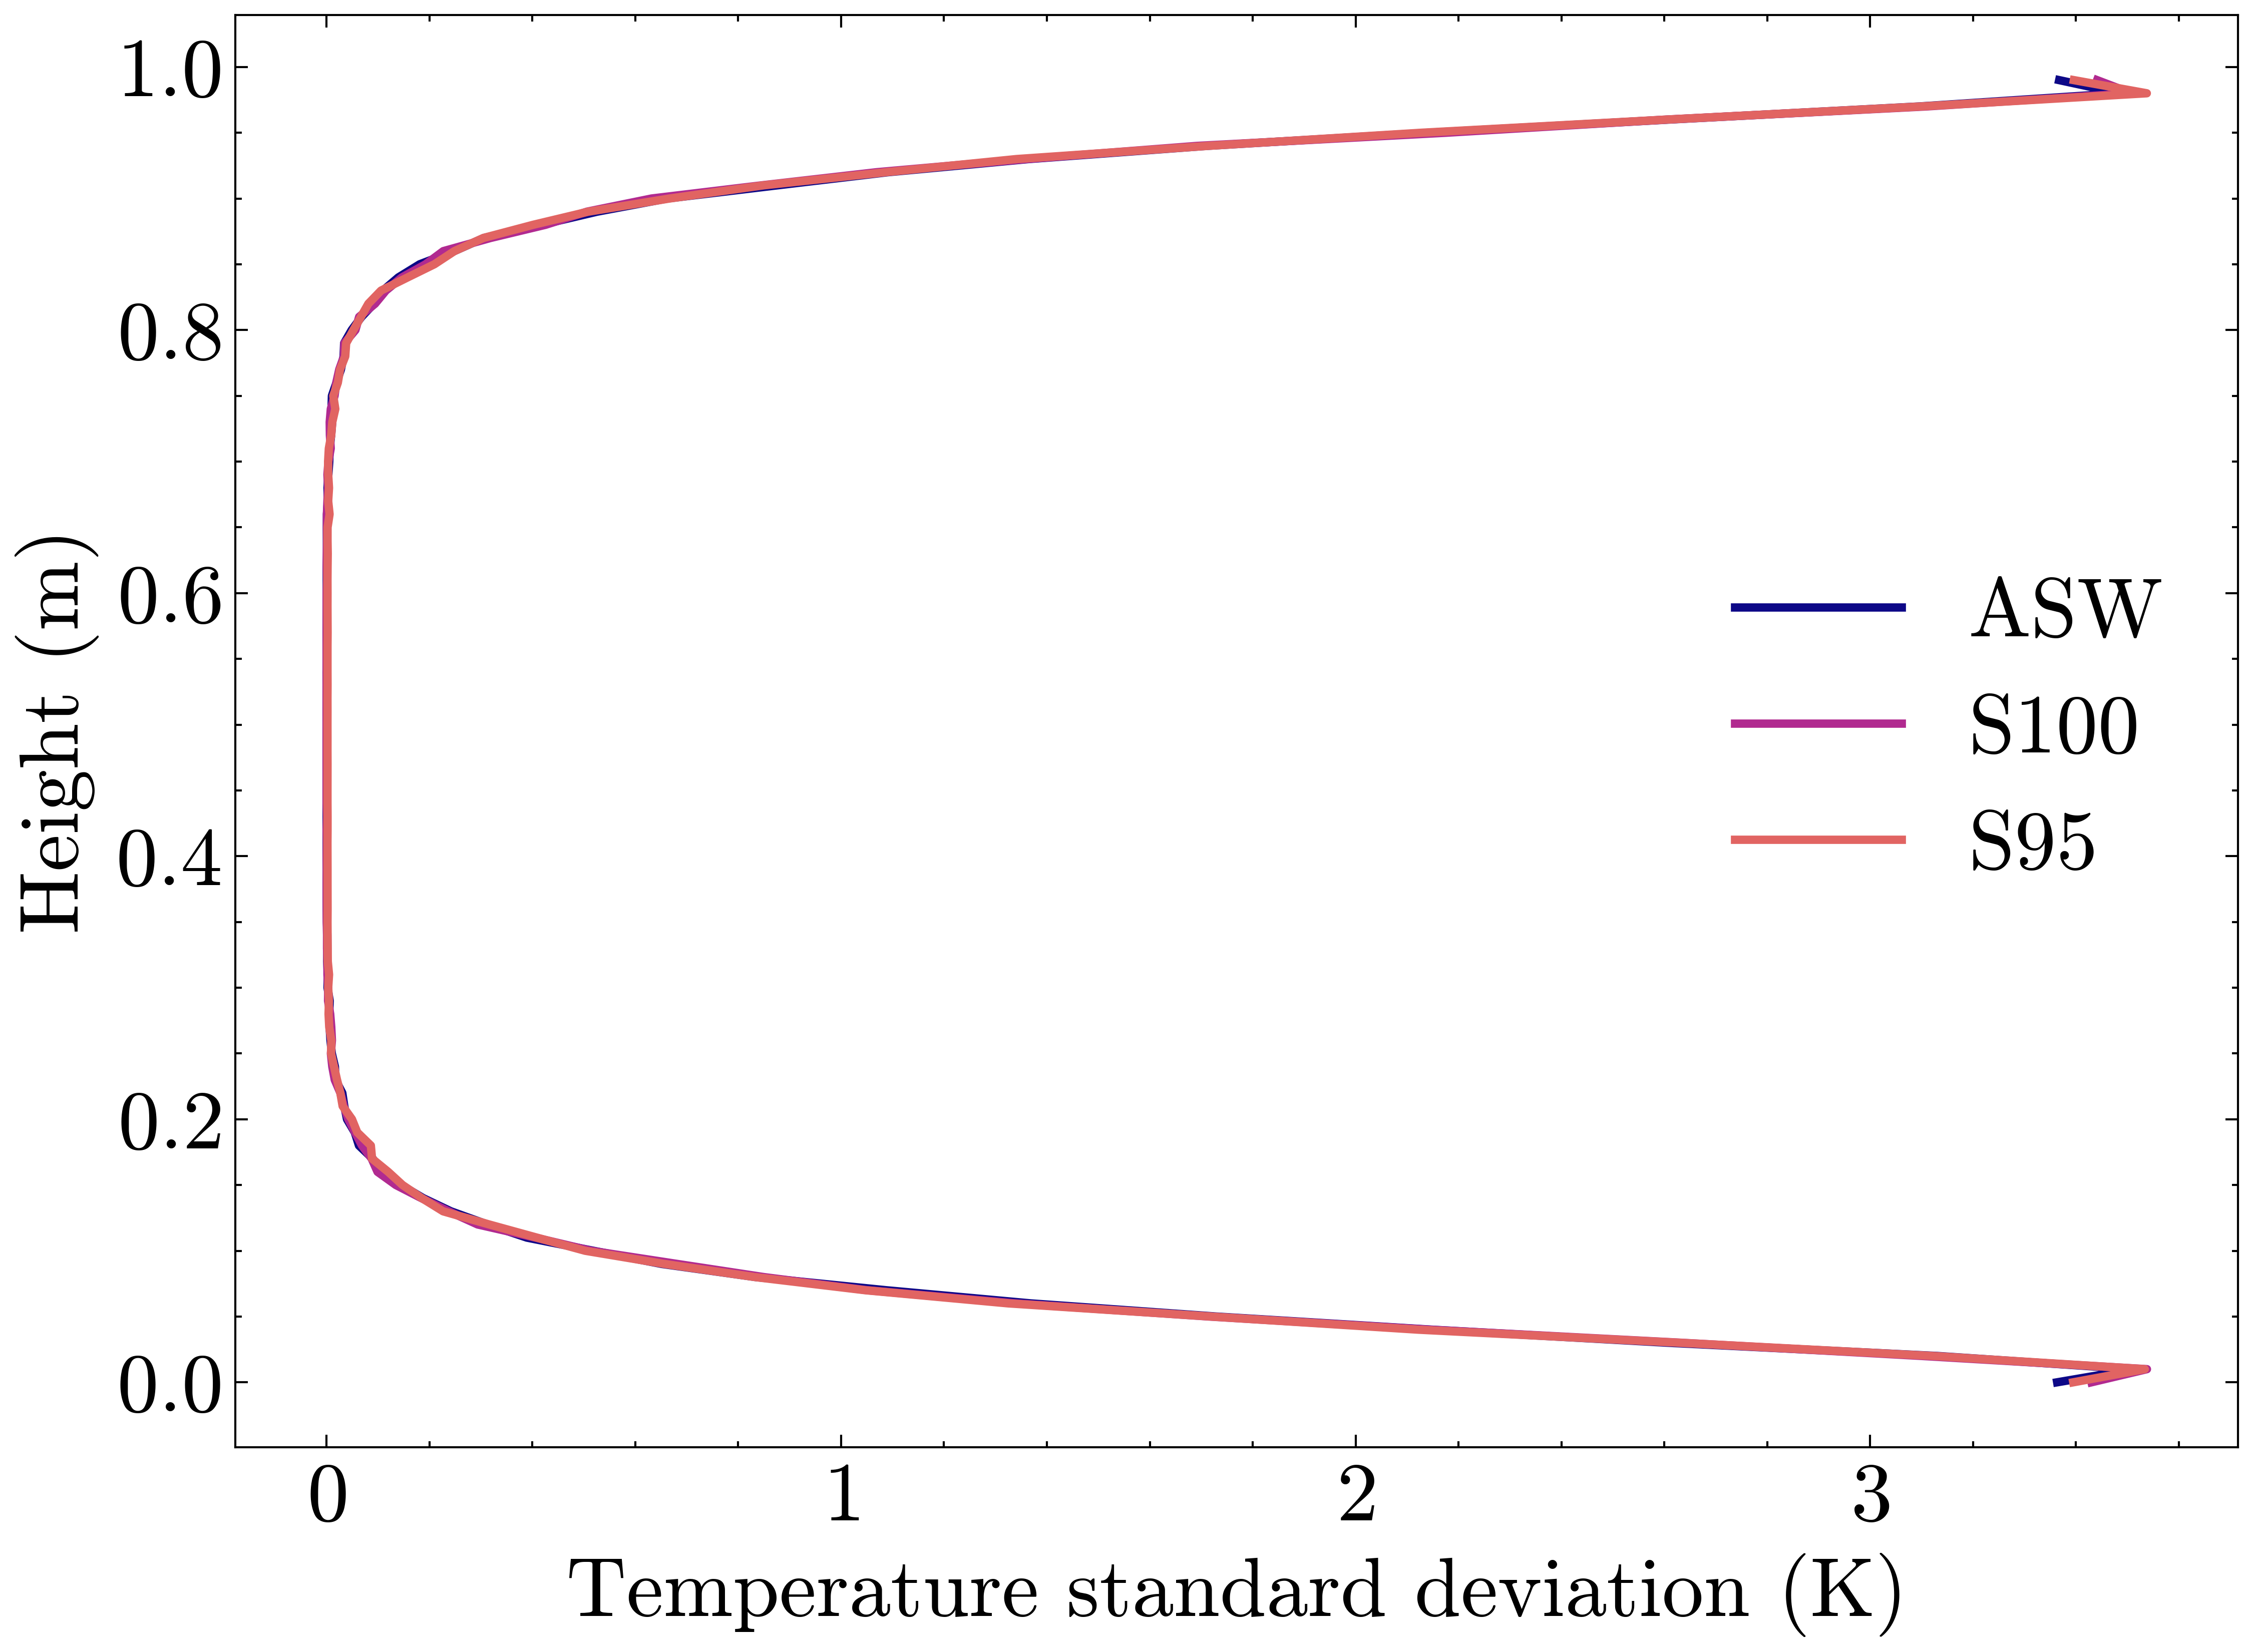

In [50]:
cmap = cm.get_cmap('plasma', 6) 
colors = cmap(np.linspace(0, 1, 6))


try:
    import scienceplots
    plt.style.use(['science', 'ieee', 'no-latex'])  # PRX-style approximation
except ImportError:
    print("scienceplots not found. Using default style.")
    plt.style.use('default')

# Adjust font sizes (slightly smaller than before)
plt.rcParams.update({
    'font.size': 20,          # Base font size
    'axes.titlesize': 20,     # Title
    'axes.labelsize': 20,     # Axis labels
    'legend.fontsize': 20,    # Legend
    'xtick.labelsize': 20,    # Tick labels
    'ytick.labelsize': 20
})



# Create scatter plot
plt.figure(figsize=(8, 6))


plt.plot(stripes['lisTstdASW'], yStripes, color=colors[0],linestyle='-', linewidth=2, label='ASW')
plt.plot(stripes['lisTstds100'], yStripes, color=colors[2], linestyle='-', linewidth=2,label='S100')
plt.plot(stripes['lisTstds95'], yStripes, color=colors[3],linestyle='-', linewidth=2, label='S95')


# Add labels and title
plt.xlabel('Temperature standard deviation (K)')
plt.ylabel('Height (m)')
plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("Temp_std_sw.png", dpi=300, bbox_inches='tight')
plt.show()